# Learn actively, and listen carefully to small-text

In this tutorial, you will learn how to set up a complete active learning loop without leaving the Rubrix UI:
 - Use the excellent small-text library to set up your active learner;
 - Use a Rubrix listener to build and start an active learning loop;
 - Use the Rubrix UI to annotate examples and learn actively;

In [ ]:
%pip install datasets small-text scikit-learn

In [12]:
import datasets

trec = datasets.load_dataset('trec')

  0%|          | 0/2 [00:00<?, ?it/s]

## Preprocess data

In [8]:
from transformers import AutoTokenizer

# Choose transformer model
TRANSFORMER_MODEL = "google/electra-small-discriminator"

# Init tokenizer
tokenizer = AutoTokenizer.from_pretrained(TRANSFORMER_MODEL)

In [3]:
def tokenize(examples):
    return tokenizer(examples["text"], padding="max_length", max_length=64, truncation=True)

# Tokenize data
trec_tokenized = trec.map(tokenize, batched=True, remove_columns=["text"])

# Set convenient output format 
trec_tokenized.set_format("torch")

Loading cached processed dataset at /home/david/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9/cache-50229829eeb8c50c.arrow
Loading cached processed dataset at /home/david/.cache/huggingface/datasets/trec/default/1.1.0/751da1ab101b8d297a3d6e9c79ee9b0173ff94c4497b75677b59b61d5467a9b9/cache-12092026cd66d70b.arrow


In [9]:
from small_text.integrations.transformers import TransformersDataset
from small_text.base import LABEL_UNLABELED

# Create small text datasets
data = [
    # Need to add an extra dimension to indicate a batch size of 1 -> [None]
    (row["input_ids"][None], row["attention_mask"][None], LABEL_UNLABELED) 
    for row in trec_tokenized["train"]
]
dataset = TransformersDataset(data)

In [10]:
# Create test dataset
data_test = [
    (row["input_ids"][None], row["attention_mask"][None], int(row["label-coarse"])) 
    for row in trec_tokenized["test"]
]
dataset_test = TransformersDataset(data_test)

## Set up active learner

In [11]:
from small_text.integrations.transformers.classifiers.factories import TransformerBasedClassificationFactory
from small_text.integrations.transformers import TransformerModelArguments
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner


# Define our classifier
clf_factory = TransformerBasedClassificationFactory(
    TransformerModelArguments(TRANSFORMER_MODEL),
    6,
    kwargs=dict({'device': 'cuda'})
)

# Define our query strategy
query_strategy = BreakingTies()

# Use the active learner with a pool-based sampling 
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

## Set up Rubrix dataset

In [6]:
import rubrix as rb

DATASET_NAME = "trec_with_active_learning"


# Define labeling schema
labels = trec["train"].features["label-coarse"].names
settings = rb.TextClassificationSettings(label_schema=labels)

# Create dataset with a label schema
rb.configure_dataset(name=DATASET_NAME, settings=settings)

In [ ]:
from small_text.initialization import random_initialization
import numpy as np
# Fix seed for reproducibility 
np.random.seed(42)

NUM_SAMPLES = 10


# Get a few initial datapoints
initial_indices = random_initialization(dataset, NUM_SAMPLES)

# Log initial datapoints for annotation
records = [
    rb.TextClassificationRecord(
        text=trec["train"]["text"][idx], 
        metadata={"batch_id": 0},
        id=idx,
    )
    for idx in initial_indices
]
rb.log(records, DATASET_NAME)

## Start active learning loop

In [8]:
from rubrix.listeners import listener
from sklearn.metrics import accuracy_score

LABEL2INT = trec["train"].features["label-coarse"].str2int
ACCURACIES = []


@listener(
    dataset=DATASET_NAME,
    query="status:Validated AND metadata.batch_id:{batch_id}",
    condition=lambda search: search.total==NUM_SAMPLES,
    execution_interval_in_seconds=2,
    batch_id=0
)
def active_learning_loop(records, ctx):
    
    # 1. Update active learner
    y = np.array([LABEL2INT(rec.annotation) for rec in records])
    
    # initial update
    if ctx.query_params["batch_id"] == 0:
        indices = np.array([rec.id for rec in records])
        active_learner.initialize_data(indices, y)
    # update with the prior queried indices
    else:
        active_learner.update(y)
        
    # 2. Query active learner
    queried_indices = active_learner.query(num_samples=NUM_SAMPLES)
    ctx.query_params["batch_id"] += 1
    new_records = [
        rb.TextClassificationRecord(
            text=trec["train"]["text"][idx], 
            metadata={"batch_id": ctx.query_params["batch_id"]},
            id=idx,
        ) 
        for idx in queried_indices
    ]
    rb.log(new_records, DATASET_NAME)    
    
    # 3. Evaluate current classifier on a test set (optional)
    accuracy = accuracy_score(
        dataset_test.y, 
        active_learner.classifier.predict(dataset_test),
    )
    ACCURACIES.append(accuracy)

In [ ]:
active_learning_loop.start()

In [10]:
active_learning_loop.stop()

## Appendix: Simulation

In [6]:
from small_text.initialization import random_initialization
import numpy as np

np.random.seed(42)
y = np.array(trec["train"]["label-coarse"])
initial_indices = random_initialization(dataset, n_samples=20)
active_learner.initialize_data(initial_indices, y[initial_indices])

In [29]:
from sklearn.metrics import accuracy_score

predictions = active_learner.classifier.predict(dataset_test)
accuracy_score(dataset_test.y, predictions)

0.192

In [30]:
accuracies = []

for i in range(20):
    print(f"Iteration: {i}", len(active_learner.indices_labeled))
    
    predictions = active_learner.classifier.predict(dataset_test)
    accuracies.append(accuracy_score(dataset_test.y, predictions))
    
    indices_queried = active_learner.query(num_samples=20)
    y = trec_tokenized["train"]["label-coarse"][indices_queried].numpy()
    active_learner.update(y)

Iteration: 0 20
Iteration: 1 40
Iteration: 2 60
Iteration: 3 80
Iteration: 4 100
Iteration: 5 120
Iteration: 6 140
Iteration: 7 160
Iteration: 8 180
Iteration: 9 200
Iteration: 10 220
Iteration: 11 240
Iteration: 12 260
Iteration: 13 280
Iteration: 14 300
Iteration: 15 320
Iteration: 16 340
Iteration: 17 360
Iteration: 18 380
Iteration: 19 400


<AxesSubplot:>

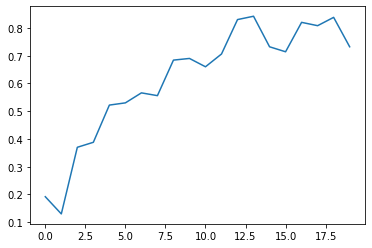

In [31]:
import pandas as pd

pd.Series(accuracies).plot()

In [34]:
idx = active_learner.indices_labeled
pd.Series(trec_tokenized["train"]["label-coarse"][idx]).value_counts()

1    104
3     86
5     84
0     73
4     66
2      7
dtype: int64

In [38]:
from sklearn.metrics import classification_report

print(classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test)))

              precision    recall  f1-score   support

           0       0.72      0.95      0.82       138
           1       0.83      0.80      0.82        94
           2       0.00      0.00      0.00         9
           3       0.87      0.94      0.90        65
           4       0.98      0.51      0.67       113
           5       0.81      0.98      0.88        81

    accuracy                           0.81       500
   macro avg       0.70      0.70      0.68       500
weighted avg       0.82      0.81      0.79       500



/home/david/miniconda3/envs/rubrix/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/miniconda3/envs/rubrix/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/david/miniconda3/envs/rubrix/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

# With sklearn

## Preprocess data

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Extract the text features
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(trec["train"]["text"])

In [14]:
import numpy as np
from small_text.base import LABEL_UNLABELED
from small_text.data import SklearnDataset


# Create a dataset for small-text
dataset = SklearnDataset(text_features, np.array([LABEL_UNLABELED]*len(trec["train"])))

In [15]:
# Create test dataset
dataset_test = SklearnDataset(
    vectorizer.transform(trec["test"]["text"]),
    np.array(trec["test"]["label-coarse"]),
)

## Set up Active Learner

In [16]:
from small_text.classifiers import ConfidenceEnhancedLinearSVC
from small_text.classifiers.factories import SklearnClassifierFactory
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner


# Define our classifier
clf_factory = SklearnClassifierFactory(
    base_estimator=ConfidenceEnhancedLinearSVC(), 
    num_classes=6
)

# Define our query strategy
query_strategy = BreakingTies()

# Use the active learner with a pool-based sampling 
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

## Simulation

In [19]:
from small_text.classifiers import ConfidenceEnhancedLinearSVC
from small_text.classifiers.factories import SklearnClassifierFactory
from small_text.query_strategies import BreakingTies
from small_text.active_learner import PoolBasedActiveLearner

clf_factory = SklearnClassifierFactory(
    base_estimator=ConfidenceEnhancedLinearSVC(), 
    num_classes=6
)
query_strategy = BreakingTies()
active_learner = PoolBasedActiveLearner(clf_factory, query_strategy, dataset)

In [20]:
from small_text.initialization import random_initialization
import numpy as np

np.random.seed(42)
y = np.array(trec["train"]["label-coarse"])
initial_indices = random_initialization(dataset, n_samples=20)
active_learner.initialize_data(initial_indices, y[initial_indices])

In [ ]:
from sklearn.metrics import classification_report
import pandas as pd
accuracies = []

for _ in range(20):
    acc = classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test), output_dict=True)["accuracy"]
    accuracies.append(acc)
    
    idx = active_learner.query(num_samples=20)
    active_learner.update(y[idx])
    
acc = classification_report(dataset_test.y, active_learner.classifier.predict(dataset_test), output_dict=True)["accuracy"]
accuracies.append(acc)

<AxesSubplot:>

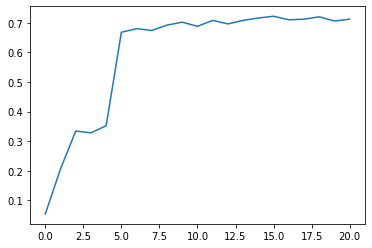

In [22]:
pd.Series(accuracies).plot()

In [22]:
accuracies[19]

0.706